In [41]:
import pickle

import numpy as np
import matplotlib.pyplot as plt

import collimator
from collimator import library
from collimator.library.quanser import animate_qube

from controllers import make_mlp_controller, make_pid, make_switched_controller
from qube_nn import run_rollout

plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'  # Change to your local path

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/jared/opt/anaconda3/envs/collimator/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:2233: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order)  # type: ignore
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=1.0, max_major_steps=1000, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=7, return_context=True), Dopri5Solver(system=Diagram(cl_system, 6 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


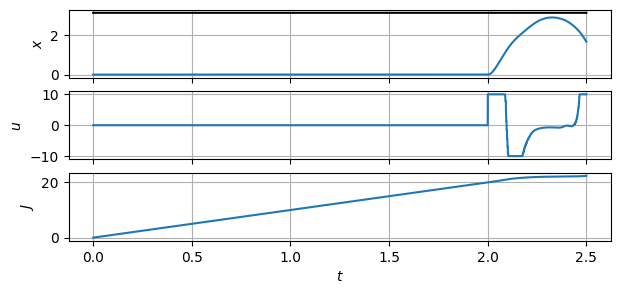

In [44]:
with open("models/swingup.pkl", "rb") as f:
    opt_params, opt_state, nn_config, sys_config = pickle.load(f)

t_offset = 2.0
rollout_config = {
    **sys_config,
    "sigma": 0.0,
    "delay": t_offset,
}
x0 = np.array([0.0, 0.0, 0.0, 0.0])
results = run_rollout(
    nn_config,
    rollout_config,
    opt_params,
    x0=x0,
    tf=2.5,
)

In [45]:
t = results.time
x = results.outputs["x"]

t_plt = np.linspace(t_offset, t[-1], 100)
x_plt = np.zeros((len(t_plt), 4))
for i in range(2):
    x_plt[:, i] = np.interp(t_plt, t, x[:, i])

plant_id = results.context.owning_system["plant"].system_id
parameters = results.context[plant_id].parameters
animate_qube(t_plt, x_plt, parameters)

Test on hardware

/Users/jared/opt/anaconda3/envs/collimator/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:2233: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order)  # type: ignore
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=1.0, max_major_steps=1000, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=7, return_context=True), Dopri5Solver(system=Diagram(cl_system, 6 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


Initialized Qube


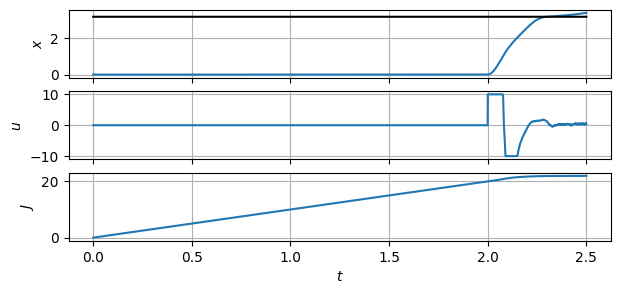

Restoring sigint handler


In [46]:

rollout_config = {**sys_config, "sigma": 0.0, "delay": t_offset}
dt = sys_config["dt"]
plant_hw = library.QuanserHAL(dt=dt, version=3, hardware=True, name="plant")
results = run_rollout(
    nn_config,
    rollout_config,
    opt_params,
    plant=plant_hw,
    tf=0.5 + t_offset,
)
plant_hw.terminate()

In [47]:
t = results.time
x = results.outputs["x"]

t_plt = np.linspace(t_offset, t[-1], 100)
x_plt = np.zeros((len(t_plt), 4))
for i in range(2):
    x_plt[:, i] = np.interp(t_plt, t, x[:, i])

animate_qube(t_plt, x_plt, parameters)

# Hybrid NN controller

Use a different net for stabilization vs swingup

In [60]:
def make_diagram(plant, nn_config, dt, sigma=0.0, delay=2.0):
    swingup_controller = make_mlp_controller(
        nn_config,
        dt,
        sigma=sigma,
        delay=delay,
        invert_input=True,
        name="nn_controller",
    )
    balance_controller = make_pid(dt)

    controller = make_switched_controller(
        swingup_controller,
        balance_controller,
        threshold=0.35,
        y_eq=np.array([0.0, np.pi]),
        control_limit=10.0,
    )

    builder = collimator.DiagramBuilder()
    builder.add(plant, controller)
    builder.connect(plant.output_ports[0], controller.input_ports[0])
    builder.connect(controller.output_ports[0], plant.input_ports[0])

    return builder.build()

In [61]:
with open("models/swingup.pkl", "rb") as f:
    opt_params, opt_state, nn_config = pickle.load(f)

plant = library.QubeServoModel(full_state_output=False, name="qube")
system = make_diagram(plant, nn_config, dt, delay=t_offset)

|-- root
    |-- qube(id=521)
    |-- controller
        |-- nn_controller
            |-- net(id=522)
            |-- theta_dot(id=523)
            |-- alpha_dot(id=524)
            |-- full_state(id=525)
            |-- y_in(id=526)
            |-- measurements(id=527)
            |-- noise(id=528)
            |-- noisy_ctrl(id=529)
            |-- zoh(id=530)
            |-- Slice_531_(id=531)
            |-- delay_switch(id=532)
            |-- u_in(id=533)
        |-- DualPID
            |-- y(id=535)
            |-- y_offset(id=536)
            |-- pid_alpha(id=537)
            |-- pid_theta(id=538)
            |-- voltage(id=539)
            |-- u(id=540)
        |-- y(id=542)
        |-- y_centered(id=543)
        |-- y_offset(id=544)
        |-- threshold(id=545)
        |-- abs_alpha(id=546)
        |-- demux(id=547)
        |-- near_upright(id=548)
        |-- switch(id=549)
        |-- voltage(id=550)


/Users/jared/opt/anaconda3/envs/collimator/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:2233: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order)  # type: ignore


collimator:INFO max_major_steps=3998 based on smallest discrete period=0.002
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=3998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=4, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


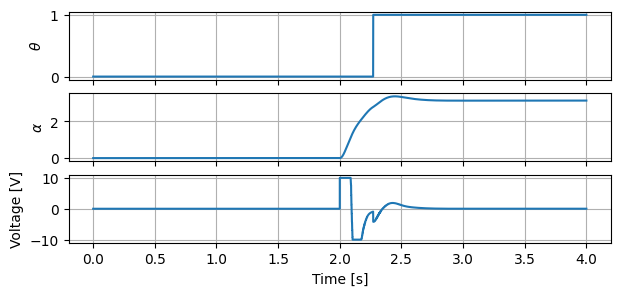

In [65]:

t0 = 0.0
tf = 2.0 + t_offset  # Feedforward time horizon

context = system.create_context()

nn_id = system["controller"]["nn_controller"]["net"].system_id
nn_context = context[nn_id].with_parameter("mlp_params", opt_params)
context = context.with_subcontext(nn_id, nn_context)

recorded_signals = {
    "y": plant.output_ports[0],
    "u": plant.input_ports[0],
    "s": system["controller"]["near_upright"].output_ports[0],
    "e": system["controller"]["nn_controller"]["full_state"].output_ports[0],
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)

t = results.time
y = results.outputs["y"]
u = results.outputs["u"]

fig, axs = plt.subplots(3, 1, figsize=(7, 3), sharex=True)
# axs[0].plot(t, y[:, 0], c='tab:blue')
axs[0].plot(t, results.outputs["s"])
axs[0].grid()
axs[0].set_ylabel(r"$\theta$")
axs[1].plot(t, y[:, 1], c='tab:blue')
axs[1].grid()
axs[1].set_ylabel(r"$\alpha$")
axs[2].plot(t, u, c='tab:blue')
axs[2].grid()
axs[2].set_ylabel("Voltage [V]")
axs[-1].set_xlabel("Time [s]")
plt.show()

In [66]:
t = results.time
x = results.outputs["y"]

t_plt = np.linspace(t_offset, t[-1], 100)
x_plt = np.zeros((len(t_plt), 4))
for i in range(2):
    x_plt[:, i] = np.interp(t_plt, t, x[:, i])

animate_qube(t_plt, x_plt, parameters)

Hardware

In [80]:

plant_hw = library.QuanserHAL(dt=dt, version=3, hardware=True, name="plant")
system = make_diagram(plant_hw, nn_config, dt, delay=t_offset)

Initialized Qube


/Users/jared/opt/anaconda3/envs/collimator/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:2233: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order)  # type: ignore


In [81]:

context = system.create_context()

nn_id = system["controller"]["nn_controller"]["net"].system_id
nn_context = context[nn_id].with_parameter("mlp_params", opt_params)
context = context.with_subcontext(nn_id, nn_context)

recorded_signals = {
    "y": plant_hw.output_ports[0],
    "u": plant_hw.input_ports[0],
    "s": system["controller"]["near_upright"].output_ports[0],
    "e": system["controller"]["nn_controller"]["full_state"].output_ports[0],
}

tf = 2.0 + t_offset  # Feedforward time horizon
results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)
plant_hw.terminate()

t = results.time
y = results.outputs["y"]
u = results.outputs["u"]


collimator:INFO max_major_steps=3998 based on smallest discrete period=0.002
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=3998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=4, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


Restoring sigint handler


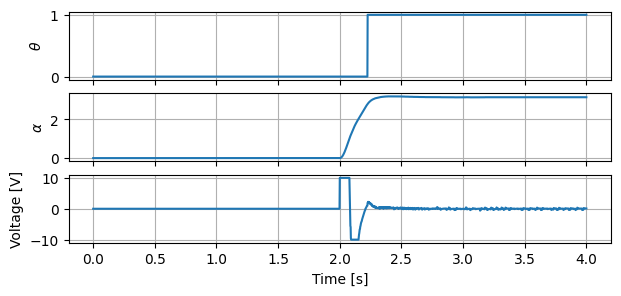

In [82]:

fig, axs = plt.subplots(3, 1, figsize=(7, 3), sharex=True)
# axs[0].plot(t, y[:, 0], c='tab:blue')
axs[0].plot(t, results.outputs["s"])
axs[0].grid()
axs[0].set_ylabel(r"$\theta$")
axs[1].plot(t, y[:, 1], c='tab:blue')
axs[1].grid()
axs[1].set_ylabel(r"$\alpha$")
axs[2].plot(t, u, c='tab:blue')
axs[2].grid()
axs[2].set_ylabel("Voltage [V]")
axs[-1].set_xlabel("Time [s]")
plt.show()